In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os

In [3]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn import model_selection
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, TimeSeriesSplit
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
import scipy.signal as sg
warnings.filterwarnings("ignore")

from scipy import stats

In [5]:
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.python.keras.layers import Dropout, Lambda
from tensorflow.python.keras.layers import ReLU, LeakyReLU, BatchNormalization, Conv1D, Flatten
from tensorflow.python.keras.layers import Add, Bidirectional, LSTM, AveragePooling2D, MaxPooling2D, MaxPooling1D
from tensorflow.python.keras.layers import Embedding, concatenate, Reshape
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow.python.keras

In [6]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow_hub as hub

# Read data

In [10]:
os.listdir('input')

['sample_submission.csv',
 'properties_2017.csv',
 'zillow_data_dictionary.xlsx',
 'train_2016_v2.csv',
 'train_2017.csv',
 'properties_2016.csv']

In [7]:
properties_2016 = pd.read_csv('./input/properties_2016.csv')

In [8]:
properties_2017 = pd.read_csv('./input/properties_2017.csv')

In [9]:
train_2016 = pd.read_csv('./input/train_2016_v2.csv')

In [10]:
train_2017 = pd.read_csv('./input/train_2017.csv')

In [11]:
test_sample = pd.read_csv('./input/sample_submission.csv')

In [15]:
train_2016.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [13]:
train_2017.head()

,parcelid,logerror,transactiondate
0,14297519,0.02559490175840,2017-01-01
1,17052889,0.05561908740150,2017-01-01
2,14186244,0.00538285304689,2017-01-01
3,12177905,-0.10340966633200,2017-01-01
4,10887214,0.00694035920822,2017-01-01


In [17]:
properties_2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.369999999998981,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.569999999999709,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.170000000000073,NaN,NaN,NaN


In [19]:
dfs = pd.read_excel('./input/zillow_data_dictionary.xlsx')

In [25]:
for i in range(len(dfs)):
    print(f"{dfs.at[i,'Feature']}: {dfs.at[i,'Description']}")

'airconditioningtypeid':  Type of cooling system present in the home (if any)
'architecturalstyletypeid':  Architectural style of the home (i.e. ranch, colonial, split-level, etc…)
'basementsqft':  Finished living area below or partially below ground level
'bathroomcnt':  Number of bathrooms in home including fractional bathrooms
'bedroomcnt':  Number of bedrooms in home 
'buildingqualitytypeid':  Overall assessment of condition of the building from best (lowest) to worst (highest)
'buildingclasstypeid': The building framing type (steel frame, wood frame, concrete/brick) 
'calculatedbathnbr':  Number of bathrooms in home including fractional bathroom
'decktypeid': Type of deck (if any) present on parcel
'threequarterbathnbr':  Number of 3/4 bathrooms in house (shower + sink + toilet)
'finishedfloor1squarefeet':  Size of the finished living area on the first (entry) floor of the home
'calculatedfinishedsquarefeet':  Calculated total finished living area of the home 
'finishedsquarefeet6

How is the 2016 property data different from 2017 property data? 

In [17]:
properties = properties_2016.append(properties_2017,ignore_index=True)

In [111]:
properties.loc[properties['parcelid']==10843547,columns[45:]]

,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
2,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.369999999998981,NaN,NaN,NaN
2985219,NaN,NaN,1959.0,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.369999999998981,NaN,NaN,NaN


Check Nan values

In [46]:
all_features = list(set(properties_2016.columns.values).difference(['parcelid']))
for feature in all_features:
    ratio = len(properties_2016.loc[properties_2016[feature].isnull()])/len(properties_2016)
    print(f'{feature}: {ratio}')

calculatedfinishedsquarefeet: 0.018613387234495852
yearbuilt: 0.020074922526570095
regionidcity: 0.0210520709214774
typeconstructiontypeid: 0.9977398627972439
garagecarcnt: 0.7041196670124819
yardbuildingsqft17: 0.9730823588368953
latitude: 0.0038312122703307665
finishedsquarefeet50: 0.9320930438222749
propertylandusetypeid: 0.0038312122703307665
storytypeid: 0.9994559859467502
pooltypeid2: 0.9892553874642949
structuretaxvaluedollarcnt: 0.018418091549123564
poolcnt: 0.8266343786733091
taxvaluedollarcnt: 0.014253570175970457
pooltypeid7: 0.8373789912090143
bathroomcnt: 0.0038395868709041924
numberofstories: 0.7715177824593656
calculatedbathnbr: 0.0431834603648579
assessmentyear: 0.0038318822383766405
threequarterbathnbr: 0.8956085939481117
taxamount: 0.010468250716782063
propertycountylandusecode: 0.004112598849597868
landtaxvaluedollarcnt: 0.022689472825593582
finishedsquarefeet13: 0.9974300025760271
lotsizesquarefeet: 0.09248875374888994
taxdelinquencyyear: 0.9810854621288838
finished

In [45]:
all_features = list(set(properties_2017.columns.values).difference(['parcelid']))
for feature in all_features:
    ratio = len(properties_2017.loc[properties_2017[feature].isnull()])/len(properties_2017)
    print(f'{feature}: {ratio}')

garagetotalsqft: 0.7015265556909264
yearbuilt: 0.016023290769146766
finishedfloor1squarefeet: 0.9317443254543974
poolcnt: 0.8192319017344468
taxdelinquencyflag: 0.9810683779437139
bedroomcnt: 0.0009865279475495417
longitude: 0.0009821731552513602
buildingclasstypeid: 0.9957353184039888
taxamount: 0.007621556489863216
propertyzoningdesc: 0.3359038890640111
calculatedbathnbr: 0.03924538819121022
pooltypeid10: 0.994303261705933
finishedsquarefeet12: 0.08858016016926072
pooltypeid7: 0.8305332577162732
taxdelinquencyyear: 0.9810677079756681
numberofstories: 0.7703094950886318
fullbathcnt: 0.03924538819121022
bathroomcnt: 0.0009905477558247858
latitude: 0.0009821731552513602
regionidneighborhood: 0.6125102463238016
taxvaluedollarcnt: 0.011478562529960134
architecturalstyletypeid: 0.9979696618369787
regionidcounty: 0.0009821731552513602
finishedsquarefeet50: 0.9317443254543974
threequarterbathnbr: 0.8940254594557112
fireplacecnt: 0.8951084628018666
censustractandblock: 0.025118776959932896
ba

In [55]:
tmp = properties_2016.loc[(properties_2016['finishedsquarefeet50'].notnull())&(properties_2016['finishedsquarefeet50']!=properties_2016['finishedfloor1squarefeet']), ['finishedsquarefeet50','finishedfloor1squarefeet']]

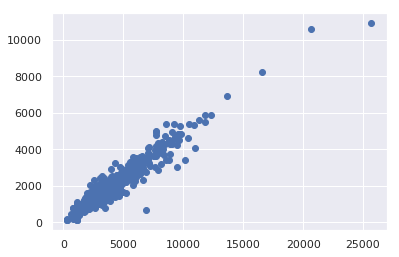

In [61]:
plt.scatter(tmp['finishedsquarefeet50'],tmp['finishedfloor1squarefeet'])

Check samples with more than one sale history records

In [36]:
train_2016_duplicate = train_2016[train_2016.duplicated('parcelid')]

In [37]:
train_2016_duplicate.head()

,parcelid,logerror,transactiondate
497,13850164,-0.0460,2016-06-29
782,14677191,-0.0845,2016-09-12
814,11005771,0.0545,2016-06-17
968,11183209,-0.0070,2016-09-14
1165,11554091,-0.0954,2016-07-05


In [38]:
train_2016.loc[train_2016['parcelid']==13850164]

,parcelid,logerror,transactiondate
496,13850164,-0.1567,2016-01-05
497,13850164,-0.0460,2016-06-29


# Outlier Plot

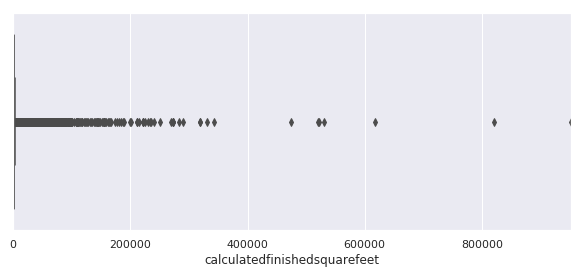

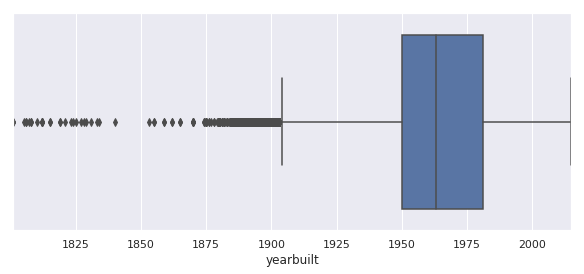

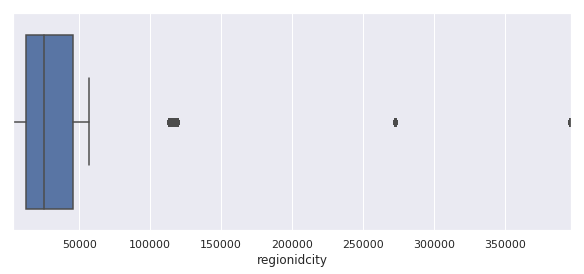

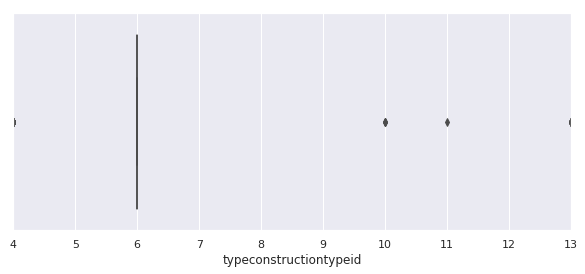

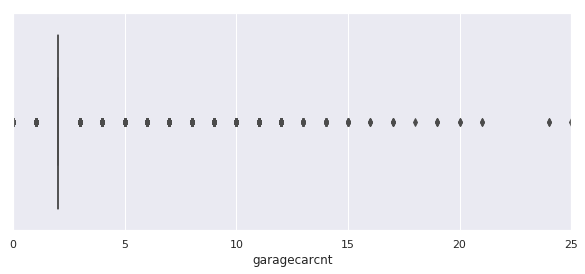

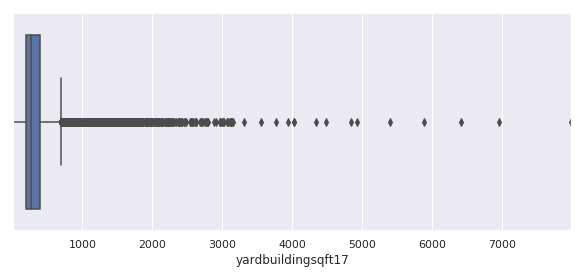

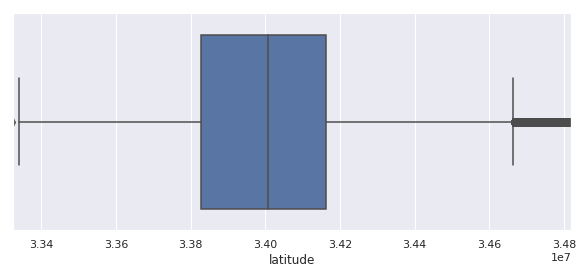

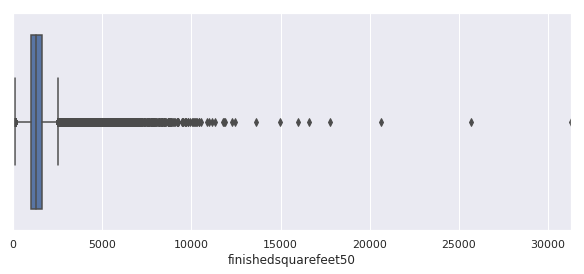

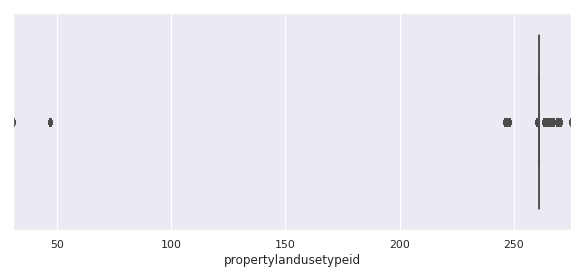

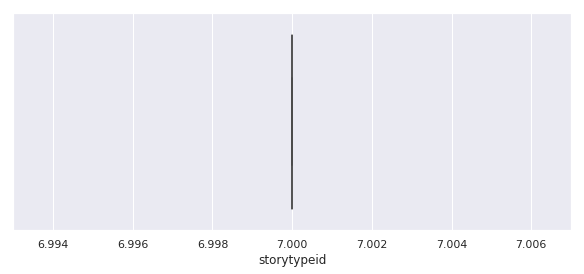

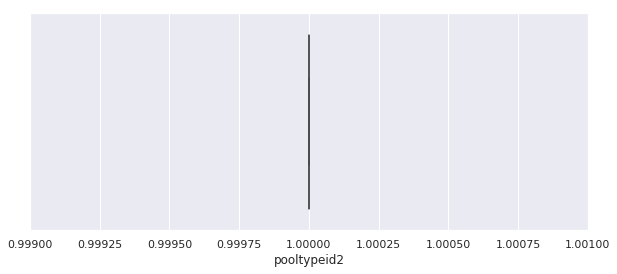

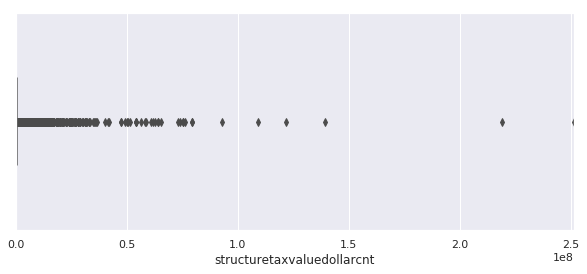

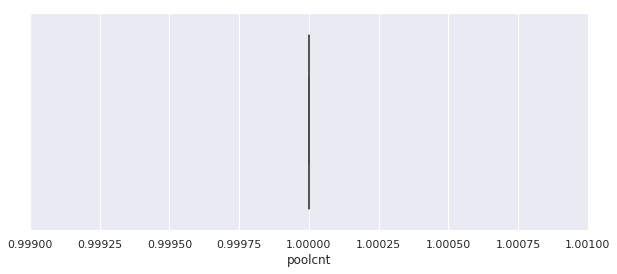

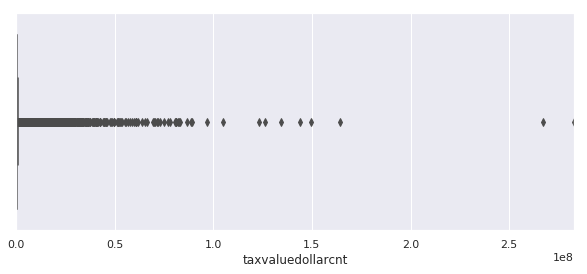

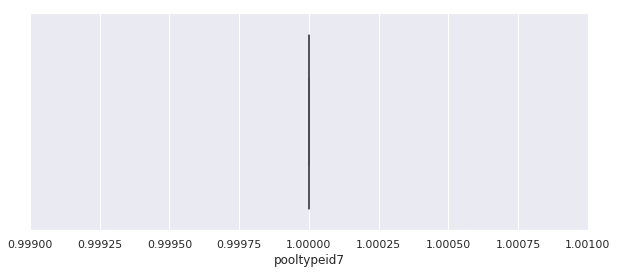

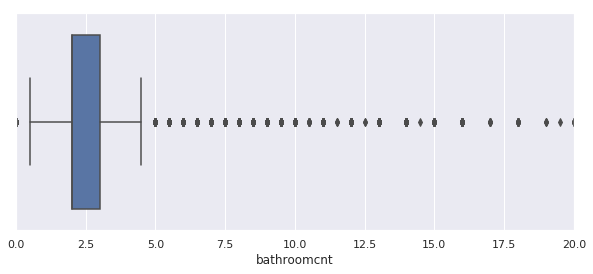

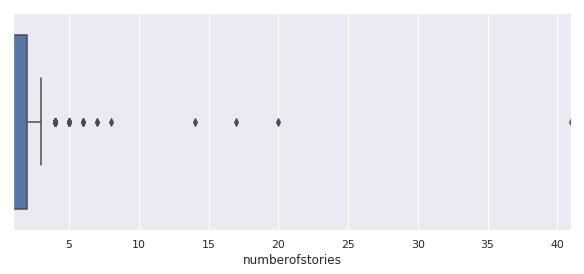

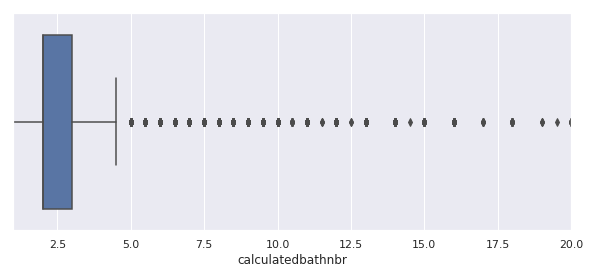

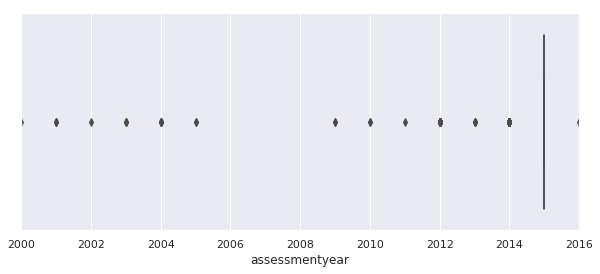

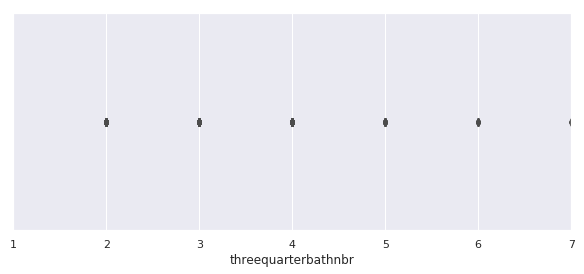

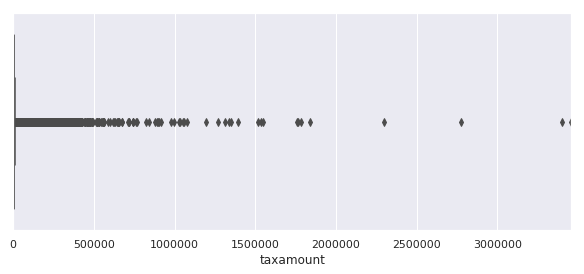

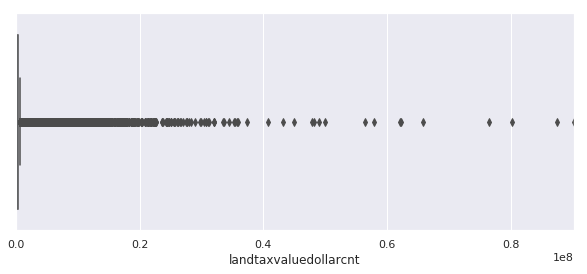

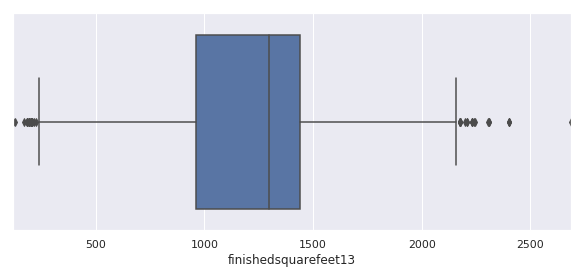

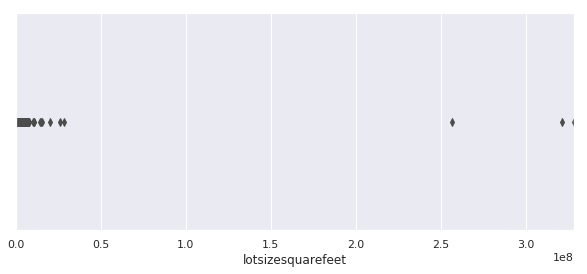

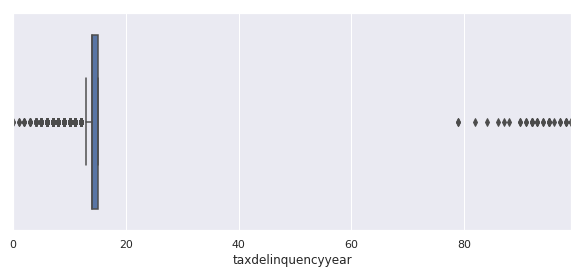

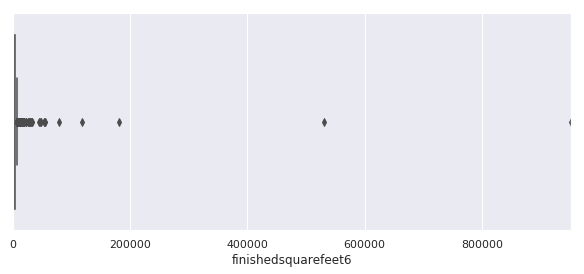

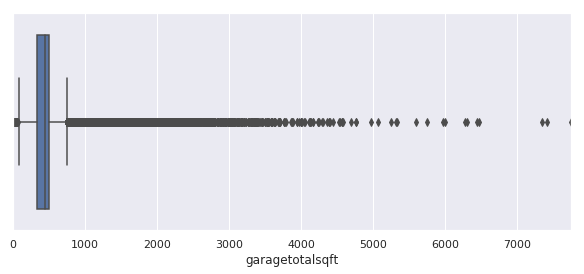

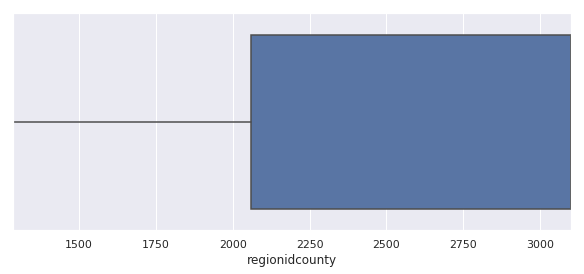

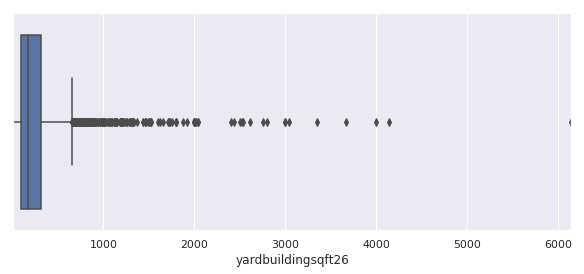

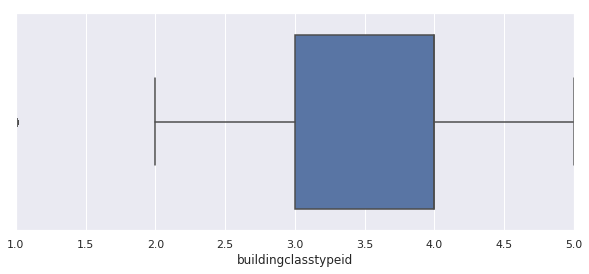

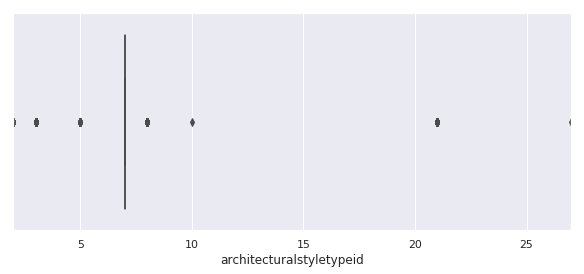

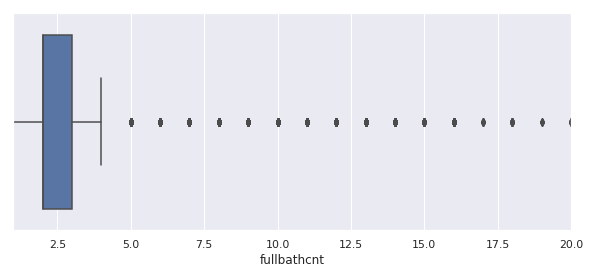

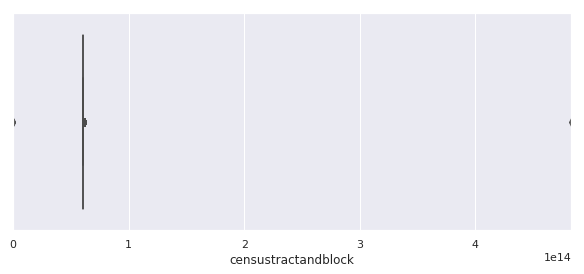

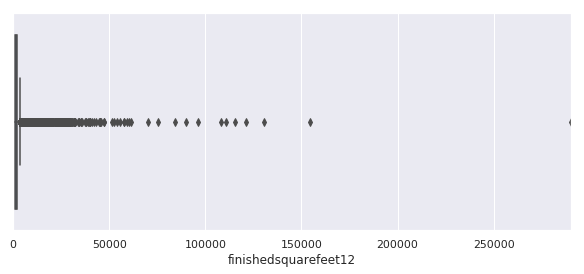

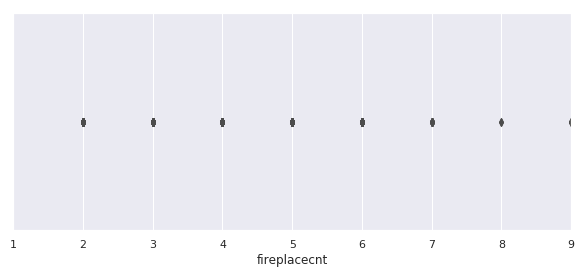

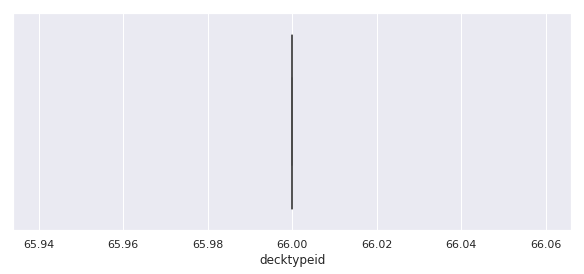

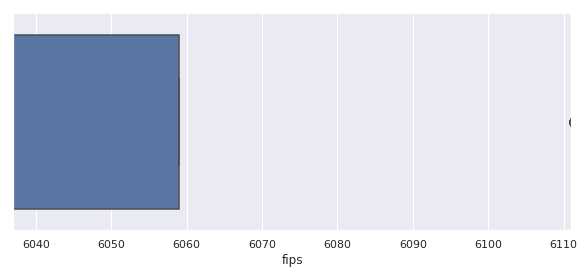

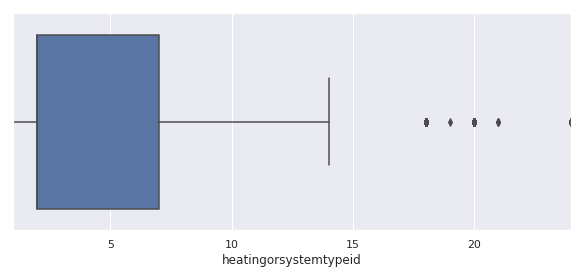

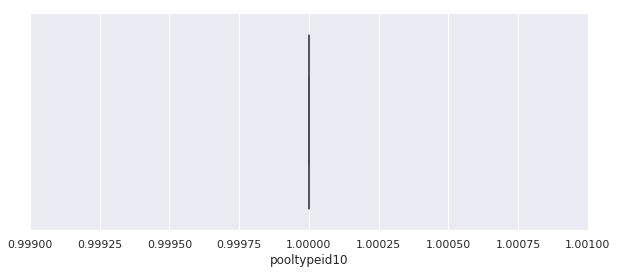

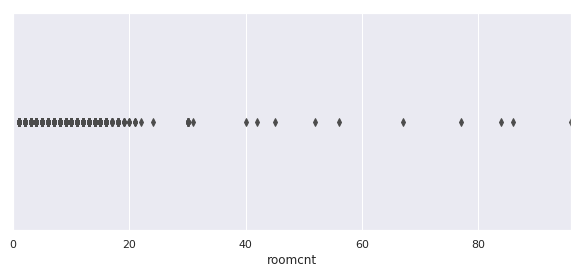

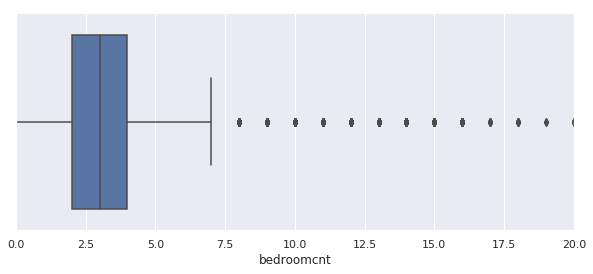

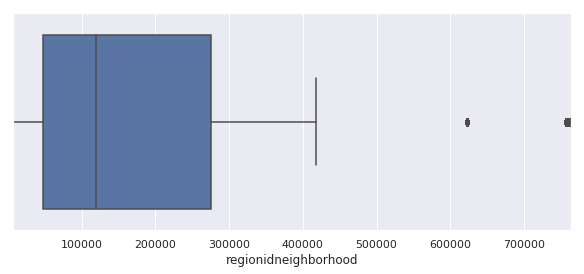

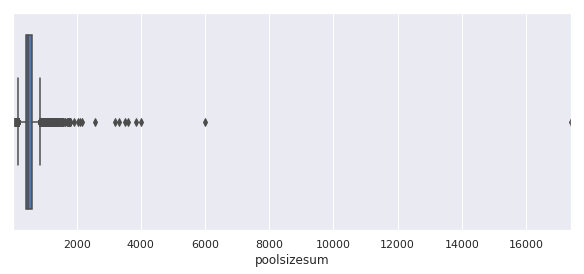

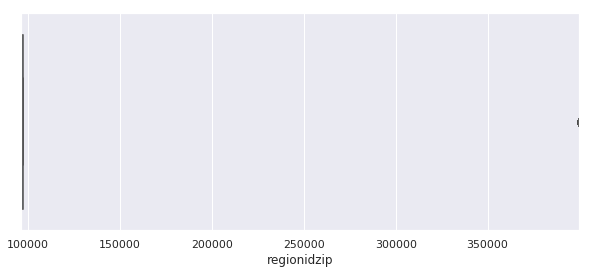

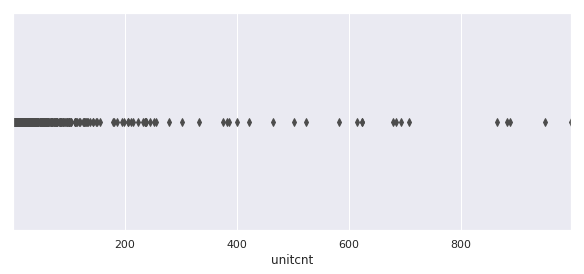

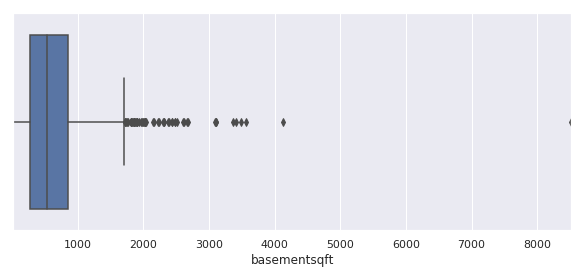

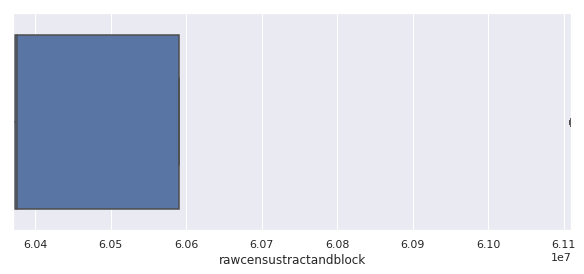

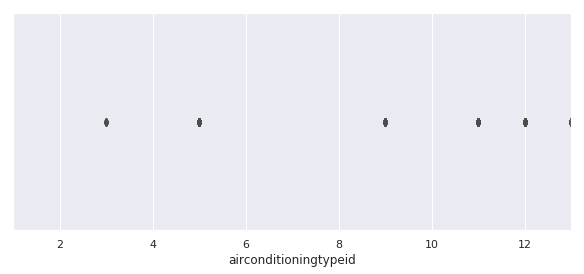

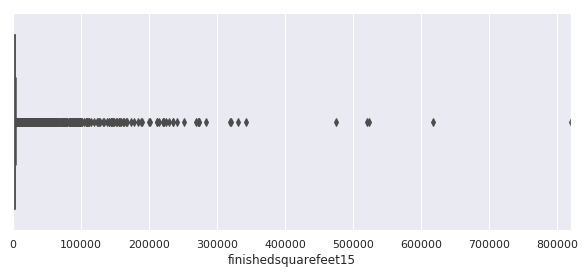

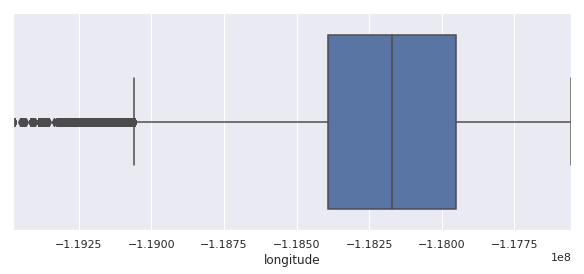

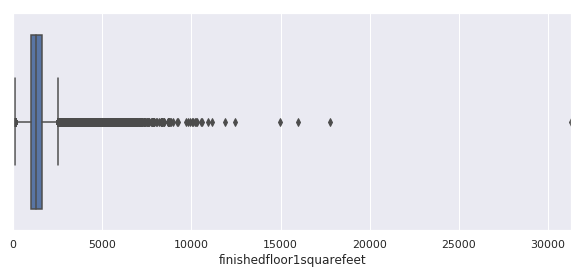

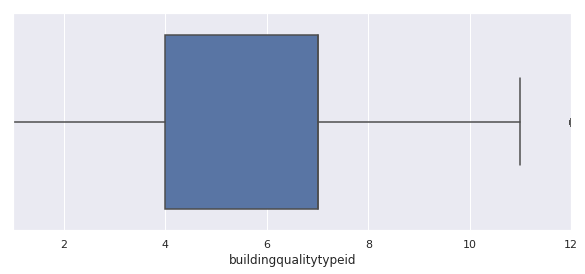

In [86]:
all_features = list(set(properties_2016.columns.values).difference(['parcelid']))
for feature in all_features:
    if properties_2016[feature].dtypes == 'object':
        continue
    plt.figure(figsize=(10,4))
    plt.xlim(properties_2016[feature].min(),properties_2016[feature].max())
    sns.boxplot(x=properties_2016[feature])

In [87]:
properties_2016['calculatedfinishedsquarefeet'].describe()

count    2.929652000000000e+06
mean     1.827162123692507e+03
std      1.819780469300116e+03
min      1.000000000000000e+00
25%      1.213000000000000e+03
50%      1.572000000000000e+03
75%      2.136000000000000e+03
max      9.525760000000000e+05
Name: calculatedfinishedsquarefeet, dtype: float64

# Distribution difference

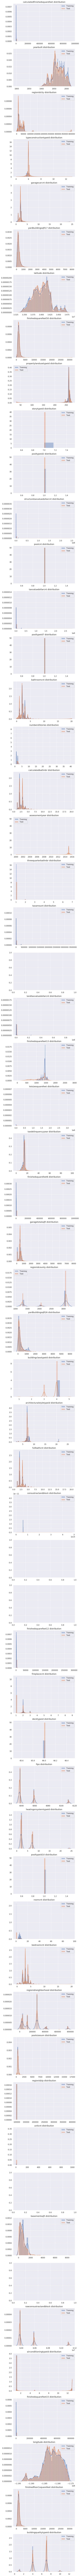

In [118]:
fig, axes = plt.subplots(ncols=1, nrows=len(all_features), figsize=(7, 300), dpi=100, squeeze = False)

for i, feature in enumerate(all_features):
    
    if properties_2016[feature].dtypes == 'object':
        continue
        
    sns.distplot(train_2016.loc[train_2016[feature].notnull(),feature], label='Training', ax=axes[i][0])
    sns.distplot(properties_2016.loc[properties_2016[feature].notnull(),feature], label='Test', ax=axes[i][0])
    
    axes[i][0].set_xlabel('')
    axes[i][0].tick_params(axis='x')
    axes[i][0].tick_params(axis='y')
    axes[i][0].legend()

    axes[i][0].set_title(f'{feature} distribution', fontsize=13)
    
#plt.show()

Can go into more details and look up the values showing in training set but not in test set

# Free Roaming

In [12]:
train = train_2016.append(train_2017,ignore_index=True)

In [13]:
train['date'] = pd.to_datetime(train['transactiondate'])

In [14]:
train['year'] = train['date'].apply(lambda x: x.year)
train['month'] = train['date'].apply(lambda x: x.month)
train['day'] = train['date'].apply(lambda x: x.day)

In [15]:
train['month_block'] = (train['year'] - 2016)*12 + train['month']

In [16]:
train.tail()

,parcelid,logerror,transactiondate,date,year,month,day,month_block
167883,10833991,-0.00224549312979,2017-09-20,2017-09-20,2017,9,20,21
167884,11000655,0.02061544092870,2017-09-20,2017-09-20,2017,9,20,21
167885,17239384,0.01320861300920,2017-09-21,2017-09-21,2017,9,21,21
167886,12773139,0.03712878670100,2017-09-21,2017-09-21,2017,9,21,21
167887,12826780,0.00720393873171,2017-09-25,2017-09-25,2017,9,25,21


In [72]:
group_month = train.groupby('month_block').agg({'logerror': ['mean']})
group_month.columns = ['logerror_mean']
group_month.reset_index(inplace = True)

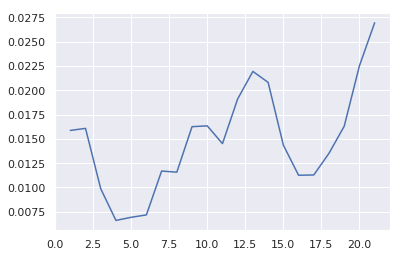

In [75]:
plt.plot(group_month['month_block'],group_month['logerror_mean'])

In [17]:
train = pd.merge(train,properties_2017,how='left',on='parcelid')

In [77]:
train.head()

,parcelid,logerror,transactiondate,date,year,month,day,month_block,airconditioningtypeid,architecturalstyletypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,2016-01-01,2016,1,1,1,1.0,NaN,...,NaN,NaN,218000.0,545000.0,2016.0,327000.0,6735.880000000000109,NaN,NaN,60371066461001.0
1,14366692,-0.1684,2016-01-01,2016-01-01,2016,1,1,1,NaN,NaN,...,NaN,NaN,346458.0,974900.0,2016.0,628442.0,10153.020000000000437,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,2016-01-01,2016,1,1,1,1.0,NaN,...,NaN,NaN,197900.0,989500.0,2016.0,791600.0,11484.479999999999563,NaN,NaN,60374638003004.0
3,12643413,0.0218,2016-01-02,2016-01-02,2016,1,2,1,1.0,NaN,...,NaN,NaN,174133.0,248613.0,2016.0,74480.0,3048.739999999999782,NaN,NaN,60372963002002.0
4,14432541,-0.0050,2016-01-02,2016-01-02,2016,1,2,1,NaN,NaN,...,2.0,NaN,172160.0,441177.0,2016.0,269017.0,5488.960000000000036,NaN,NaN,60590423381006.0


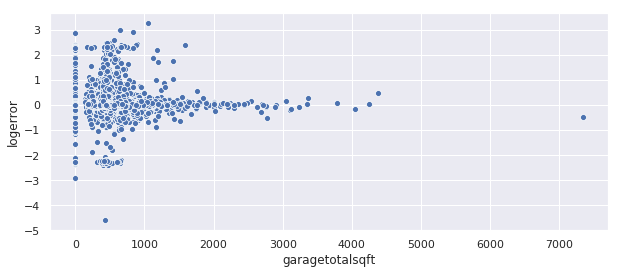

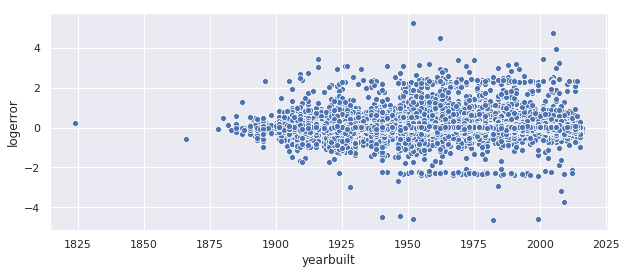

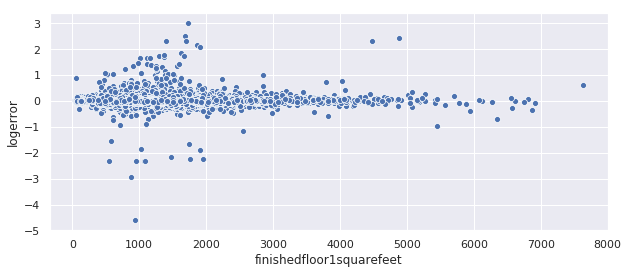

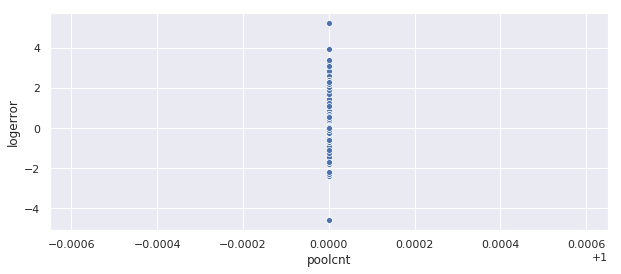

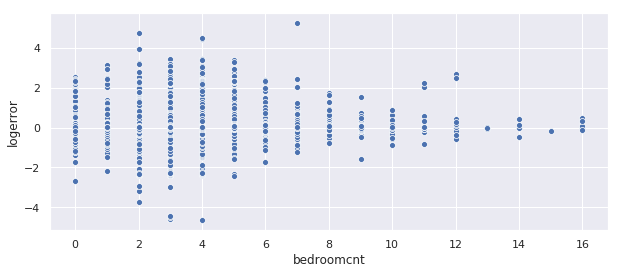

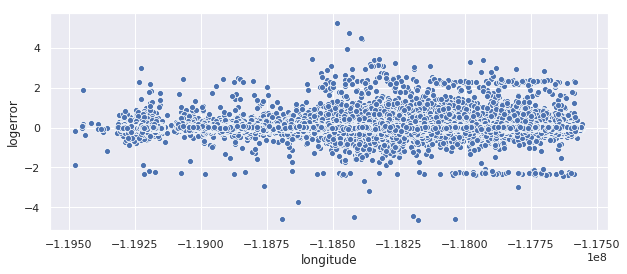

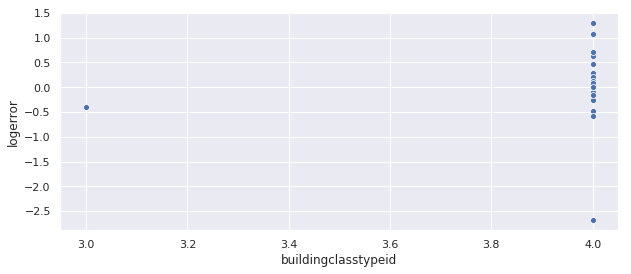

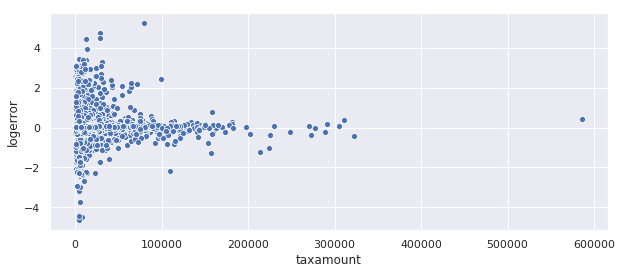

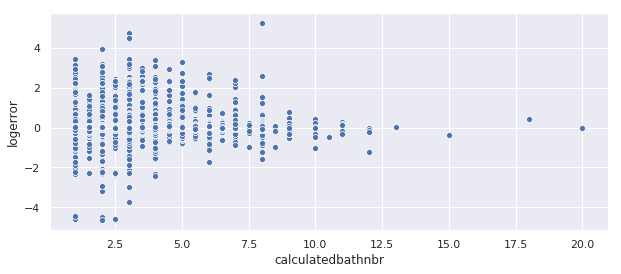

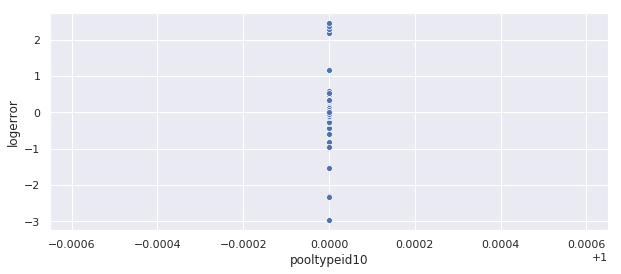

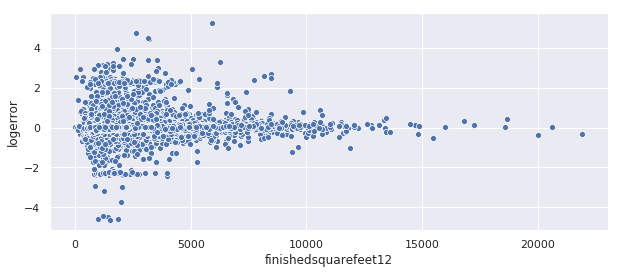

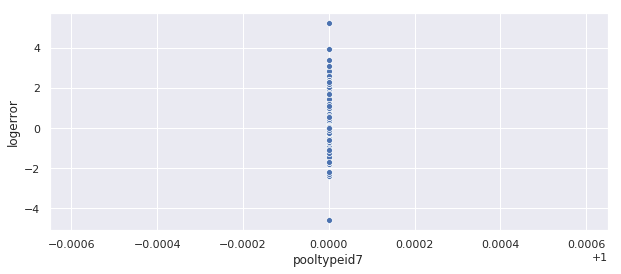

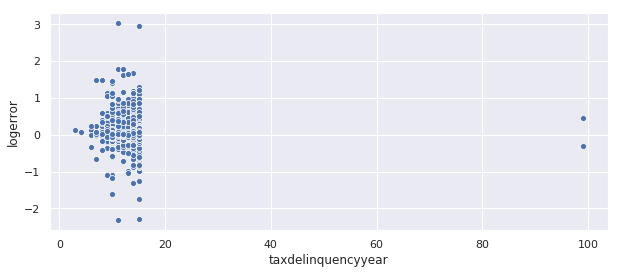

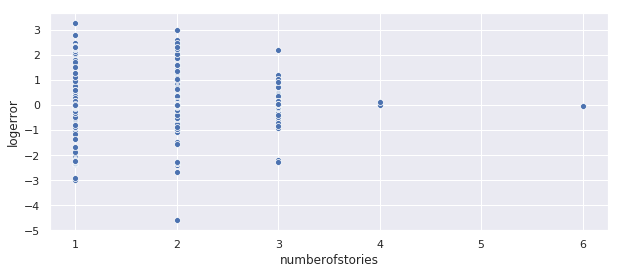

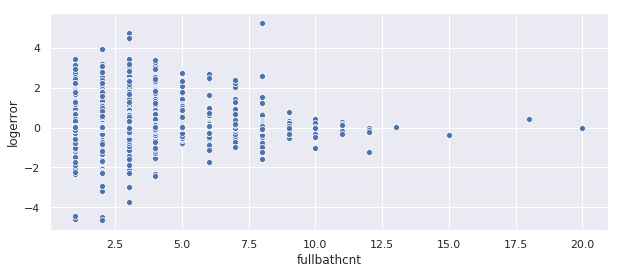

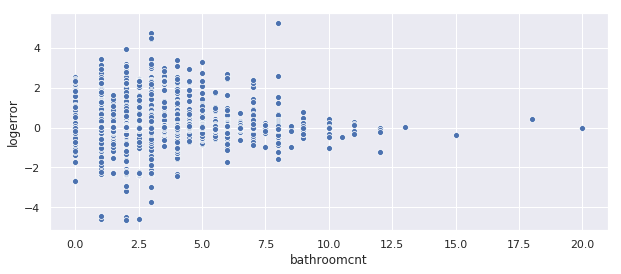

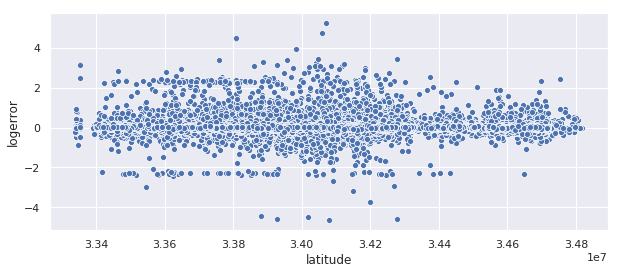

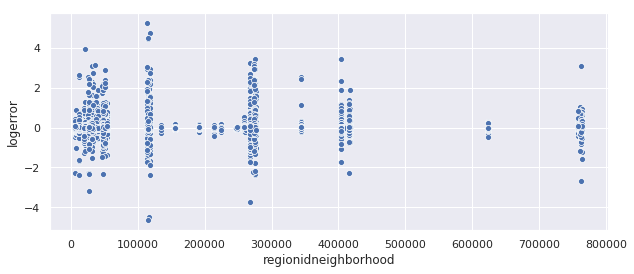

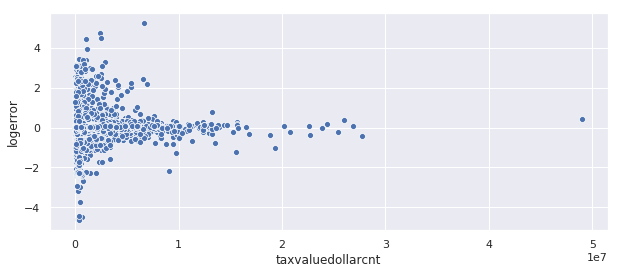

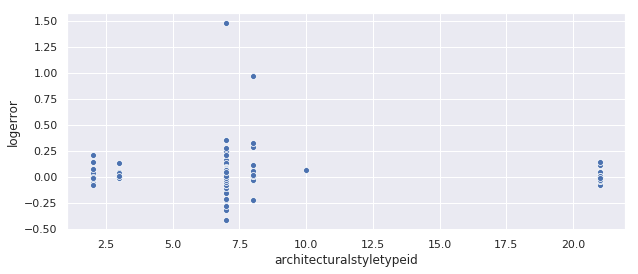

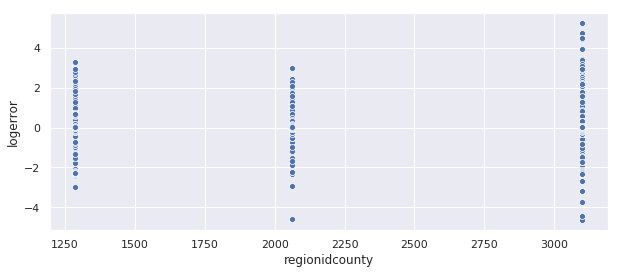

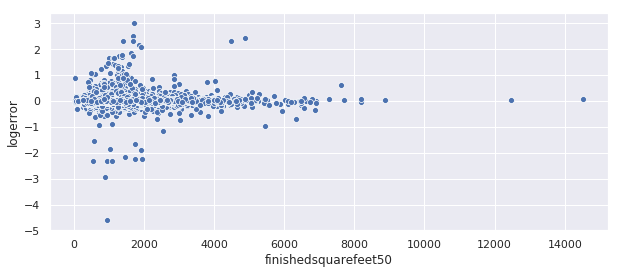

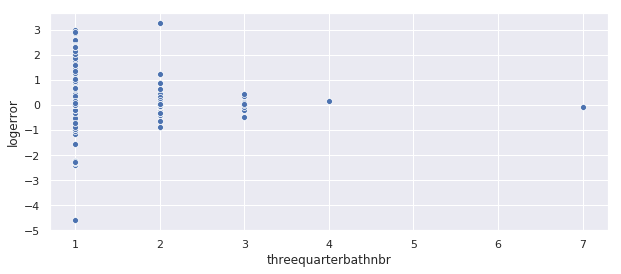

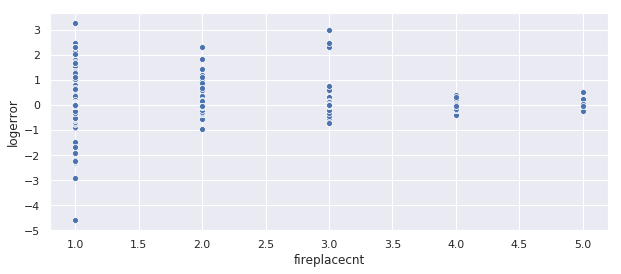

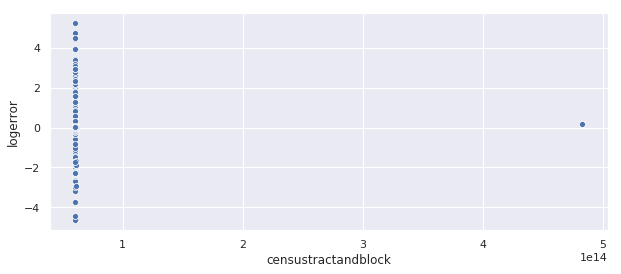

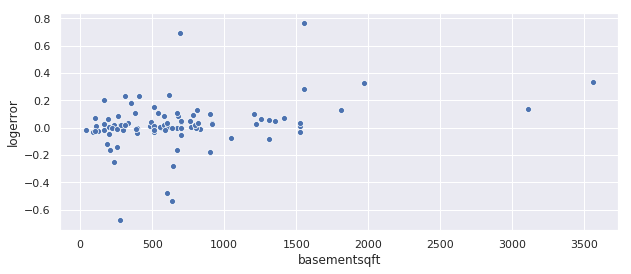

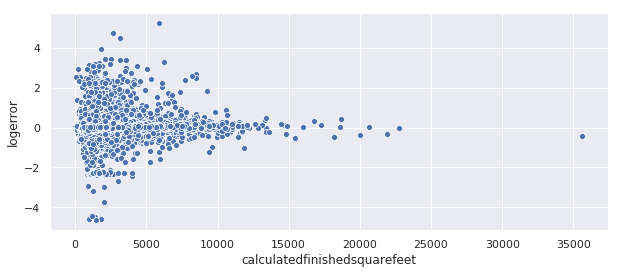

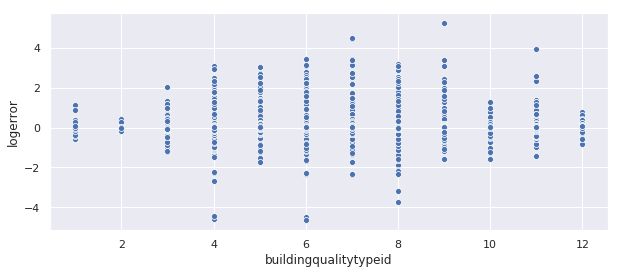

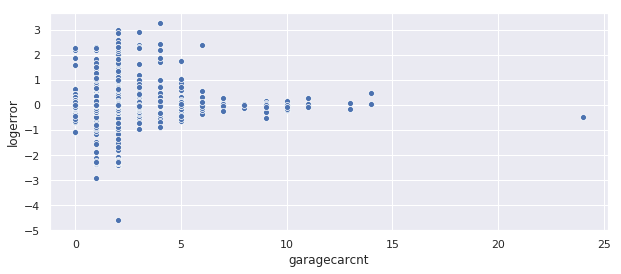

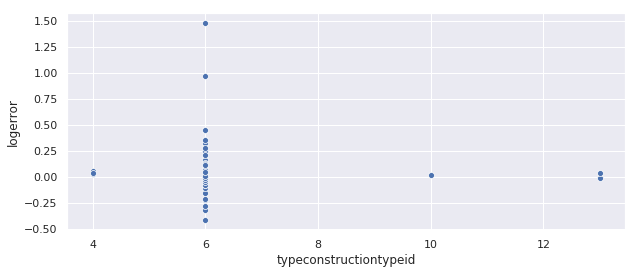

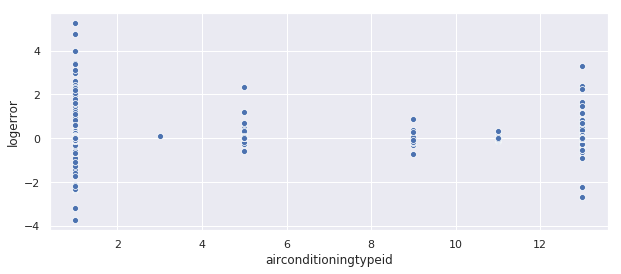

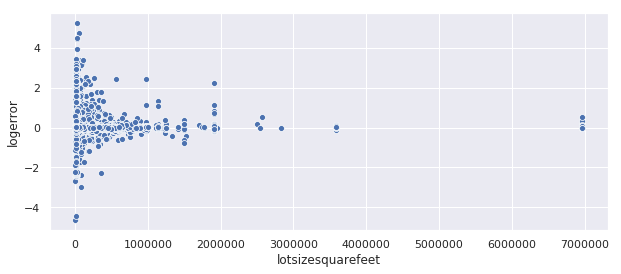

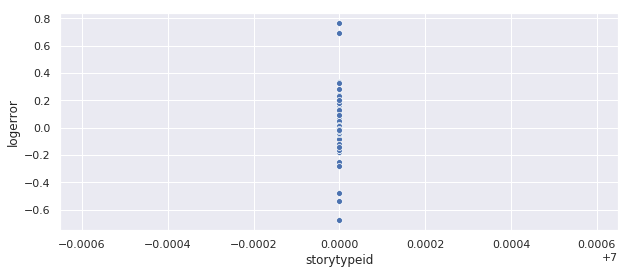

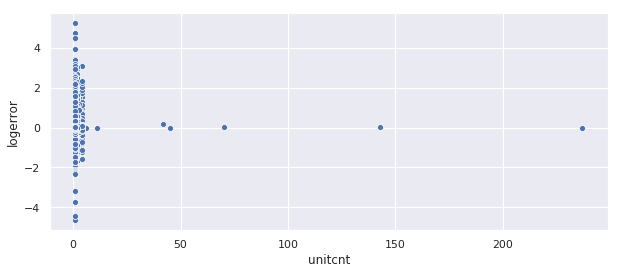

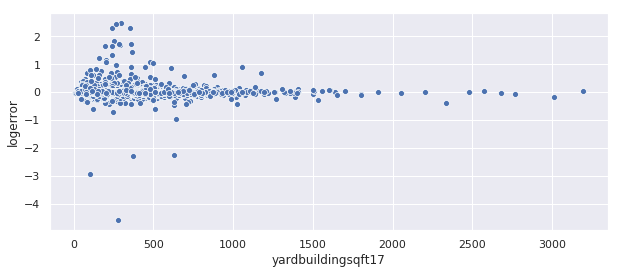

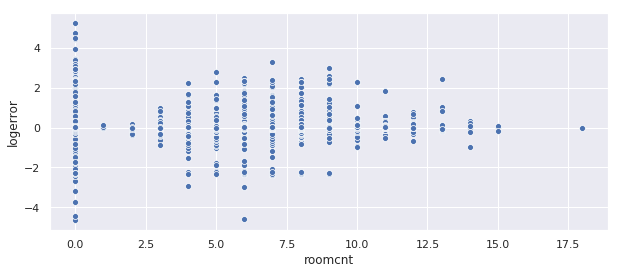

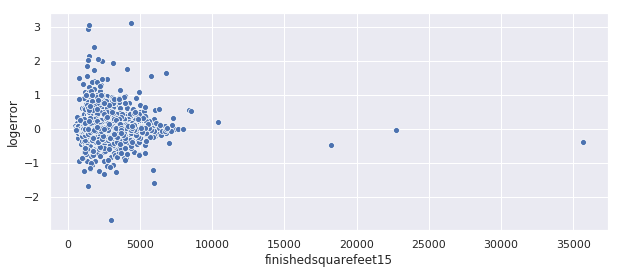

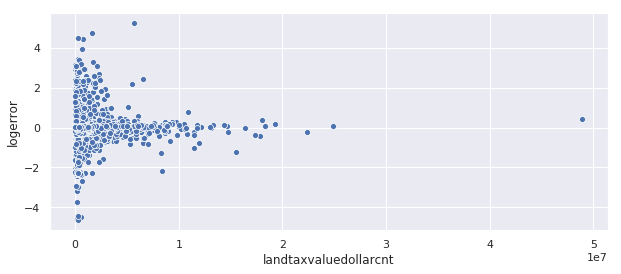

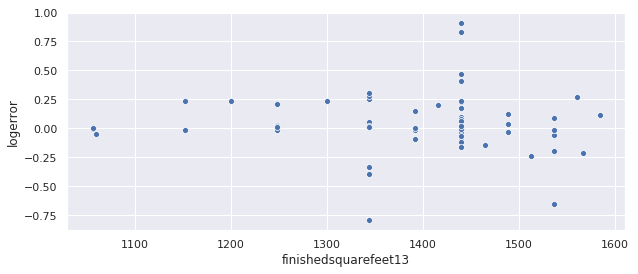

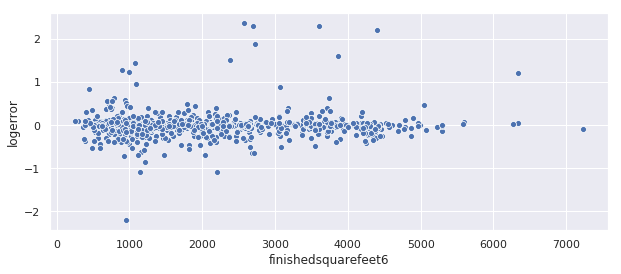

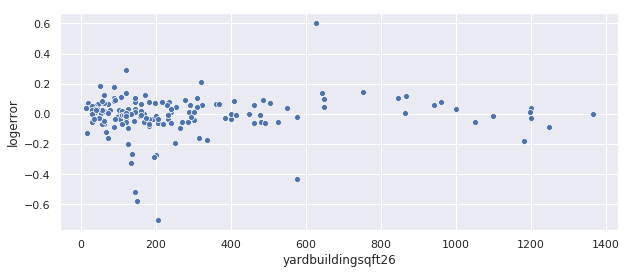

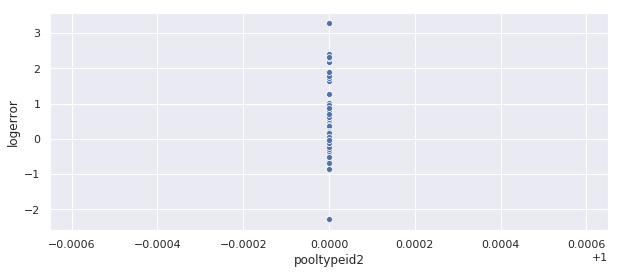

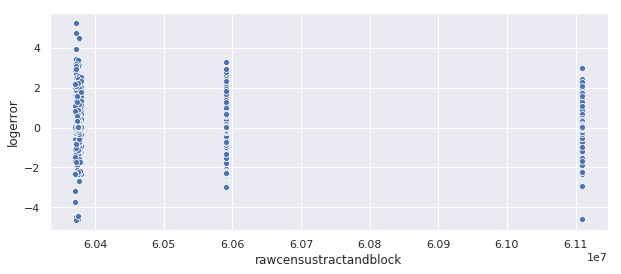

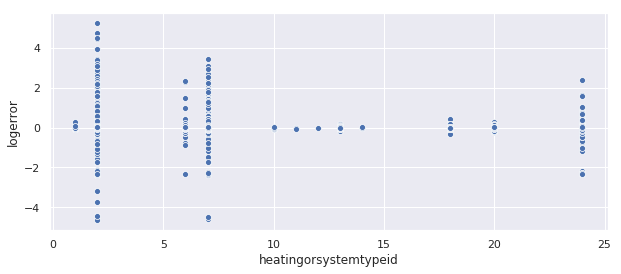

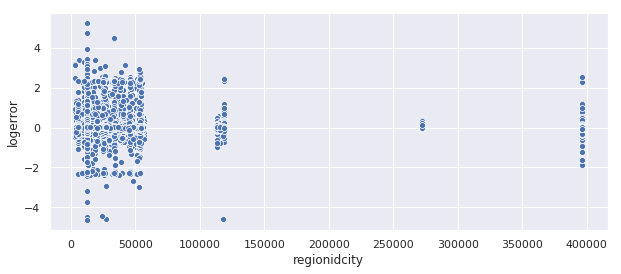

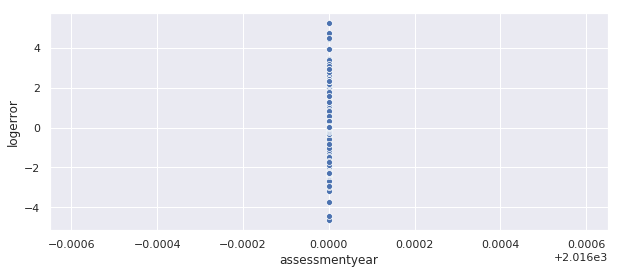

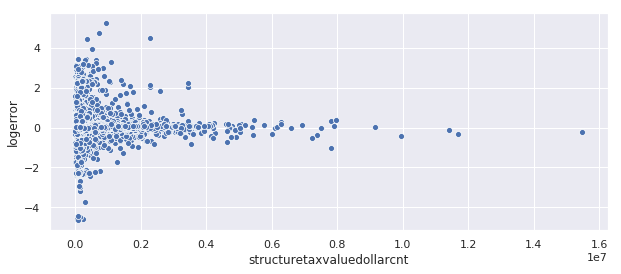

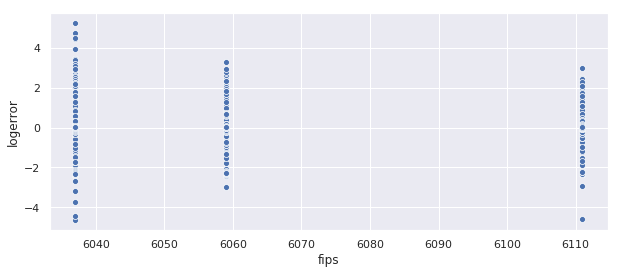

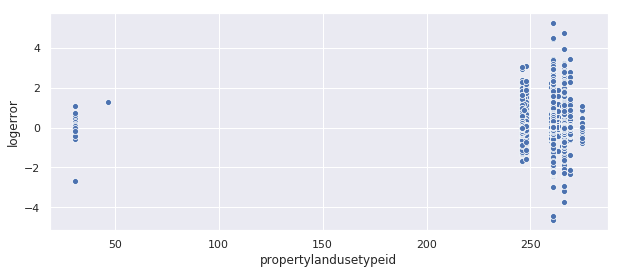

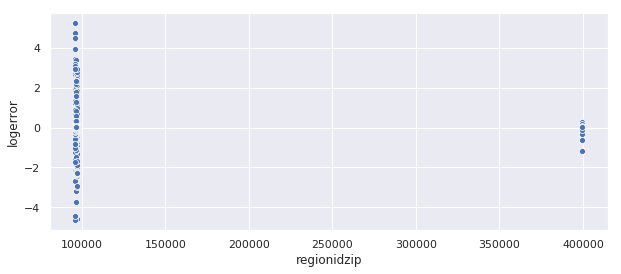

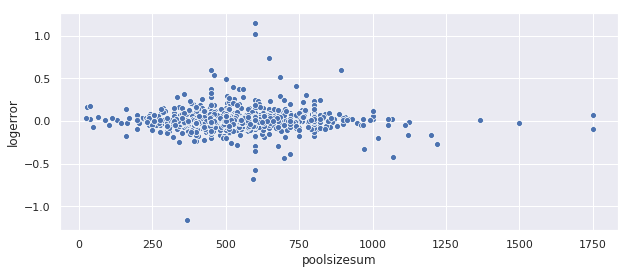

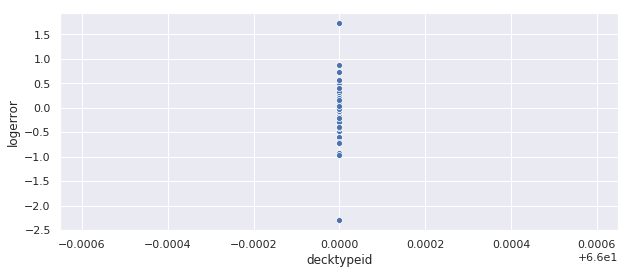

In [79]:
all_features = list(set(properties_2017.columns.values).difference(['parcelid']))
for feature in all_features:
    if properties_2016[feature].dtypes == 'object':
        continue
    plt.figure(figsize=(10,4))
    #plt.xlim(properties_2016[feature].min(),properties_2016[feature].max())
    sns.scatterplot(train[feature],train['logerror'])

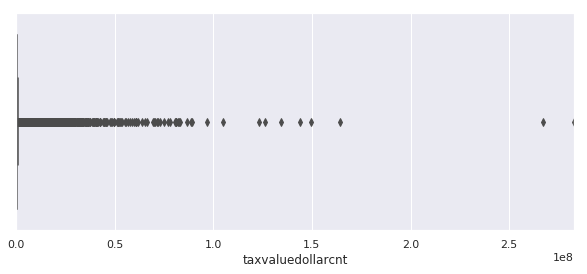

In [11]:
plt.figure(figsize=(10,4))
plt.xlim(properties_2016['taxvaluedollarcnt'].min(),properties_2016['taxvaluedollarcnt'].max())
sns.boxplot(x=properties_2016['taxvaluedollarcnt'])

In [17]:
properties_2016['taxvaluedollarcnt_processed'] = np.log(properties_2016['taxvaluedollarcnt'])

In [19]:
train_2016 = pd.merge(train_2016, properties_2016, how='left', on = ['parcelid'])

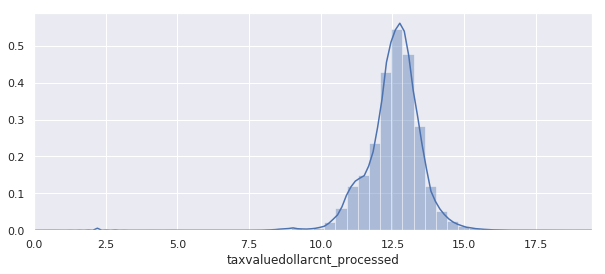

In [18]:
plt.figure(figsize=(10,4))
plt.xlim(properties_2016['taxvaluedollarcnt_processed'].min(),properties_2016['taxvaluedollarcnt_processed'].max())
sns.distplot(properties_2016.loc[properties_2016['taxvaluedollarcnt_processed'].notnull(),'taxvaluedollarcnt_processed'])

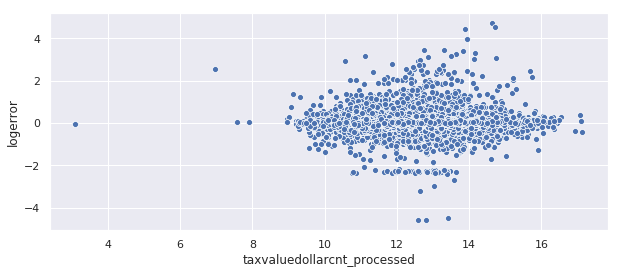

In [21]:
plt.figure(figsize=(10,4))
sns.scatterplot(train_2016['taxvaluedollarcnt_processed'],train_2016['logerror'])

In [22]:
train_2016['calculatedfinishedsquarefeet_processed'] = np.log(train_2016['calculatedfinishedsquarefeet'])

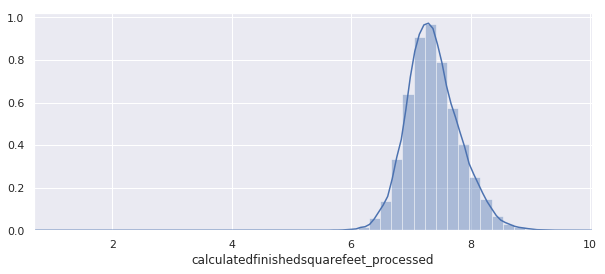

In [24]:
plt.figure(figsize=(10,4))
plt.xlim(train_2016['calculatedfinishedsquarefeet_processed'].min(),train_2016['calculatedfinishedsquarefeet_processed'].max())
sns.distplot(train_2016.loc[train_2016['calculatedfinishedsquarefeet_processed'].notnull(),'calculatedfinishedsquarefeet_processed'])

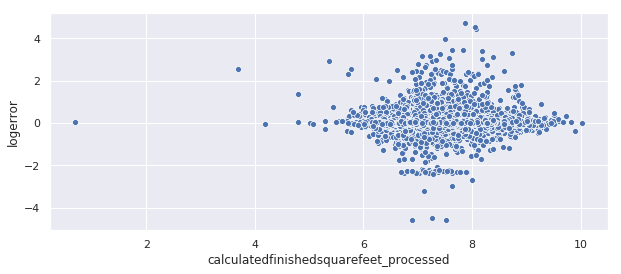

In [25]:
plt.figure(figsize=(10,4))
sns.scatterplot(train_2016['calculatedfinishedsquarefeet_processed'],train_2016['logerror'])

In [26]:
train_2016['structuretaxvaluedollarcnt_processed'] = np.log(train_2016['structuretaxvaluedollarcnt'])

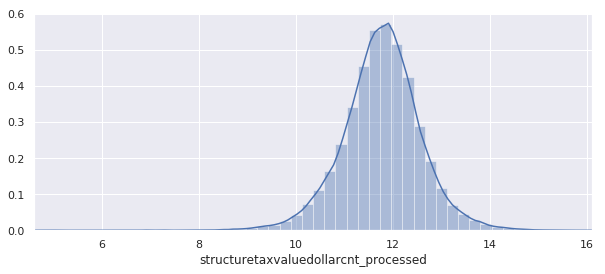

In [27]:
plt.figure(figsize=(10,4))
plt.xlim(train_2016['structuretaxvaluedollarcnt_processed'].min(),train_2016['structuretaxvaluedollarcnt_processed'].max())
sns.distplot(train_2016.loc[train_2016['structuretaxvaluedollarcnt_processed'].notnull(),'structuretaxvaluedollarcnt_processed'])

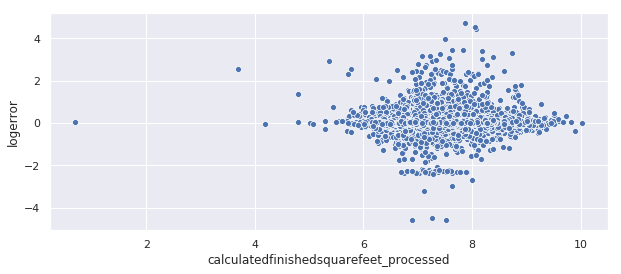

In [28]:
plt.figure(figsize=(10,4))
sns.scatterplot(train_2016['calculatedfinishedsquarefeet_processed'],train_2016['logerror'])

In [29]:
train_2016['taxamount_processed'] = np.log(train_2016['taxamount'])

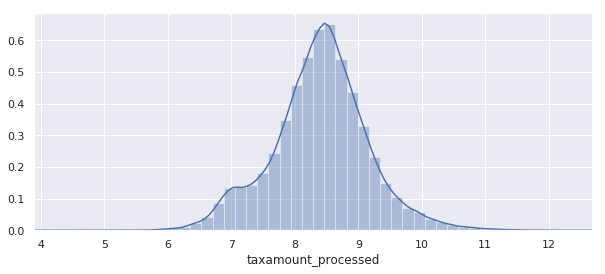

In [30]:
plt.figure(figsize=(10,4))
plt.xlim(train_2016['taxamount_processed'].min(),train_2016['taxamount_processed'].max())
sns.distplot(train_2016.loc[train_2016['taxamount_processed'].notnull(),'taxamount_processed'])

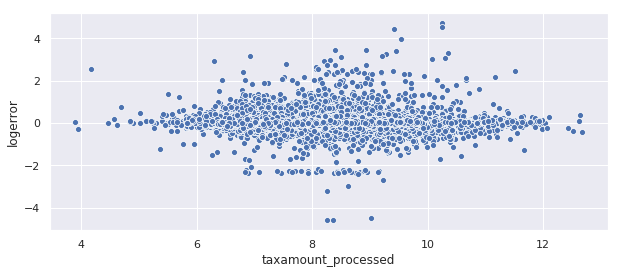

In [31]:
plt.figure(figsize=(10,4))
sns.scatterplot(train_2016['taxamount_processed'],train_2016['logerror'])

In [32]:
train_2016['landtaxvaluedollarcnt_processed'] = np.log(train_2016['landtaxvaluedollarcnt'])

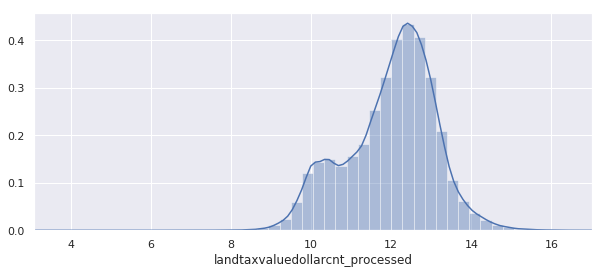

In [34]:
plt.figure(figsize=(10,4))
plt.xlim(train_2016['landtaxvaluedollarcnt_processed'].min(),train_2016['landtaxvaluedollarcnt_processed'].max())
sns.distplot(train_2016.loc[train_2016['landtaxvaluedollarcnt_processed'].notnull(),'landtaxvaluedollarcnt_processed'])

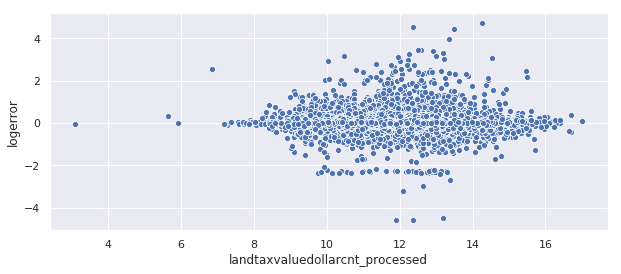

In [35]:
plt.figure(figsize=(10,4))
sns.scatterplot(train_2016['landtaxvaluedollarcnt_processed'],train_2016['logerror'])

In [38]:
train_2016['lotsizesquarefeet_processed'] = np.log(train_2016['lotsizesquarefeet'])

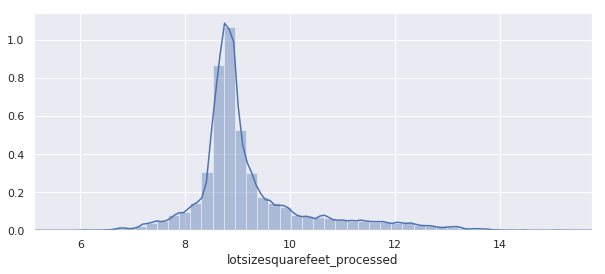

In [39]:
plt.figure(figsize=(10,4))
plt.xlim(train_2016['lotsizesquarefeet_processed'].min(),train_2016['lotsizesquarefeet_processed'].max())
sns.distplot(train_2016.loc[train_2016['lotsizesquarefeet_processed'].notnull(),'lotsizesquarefeet_processed'])

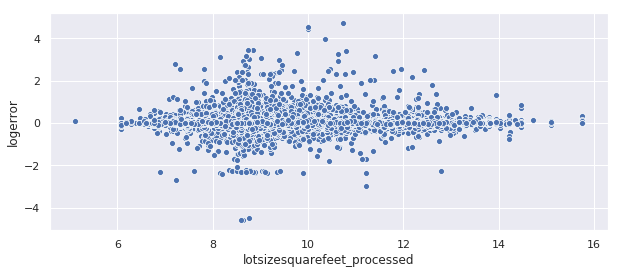

In [40]:
plt.figure(figsize=(10,4))
sns.scatterplot(train_2016['lotsizesquarefeet_processed'],train_2016['logerror'])

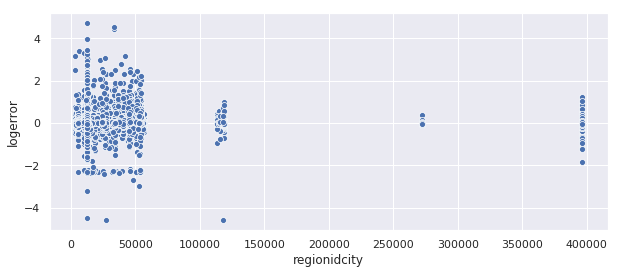

In [41]:
plt.figure(figsize=(10,4))
sns.scatterplot(train_2016['regionidcity'],train_2016['logerror'])

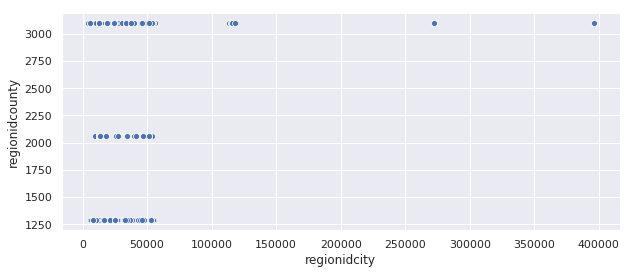

In [42]:
plt.figure(figsize=(10,4))
sns.scatterplot(train_2016['regionidcity'],train_2016['regionidcounty'])

In [45]:
counties = train_2016['regionidcounty'].unique()

In [47]:
train_2016['regionidcounty'].unique()

array([3101., 1286., 2061.])

In [50]:
len(train_2016['regionidzip'].unique()), len(train_2016['regionidcity'].unique())

(389, 178)

In [46]:
for county in counties:
    num_city = len(train_2016.loc[train_2016['regionidcounty']==county,'regionidcity'].unique())
    print(f'County {county}: {num_city}')

County 3101.0: 127
County 1286.0: 43
County 2061.0: 20
